# Creating idealized velocity and bathymetry fields
Includes:
- a temporal varying eddy
- a current jet
- a zero velocity field
- some idealized bathymetry fields

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import cmocean
import netCDF4# import Dataset

%matplotlib inline

# Creating a temporal varying eddy
Including bathymetry (ocean floor)

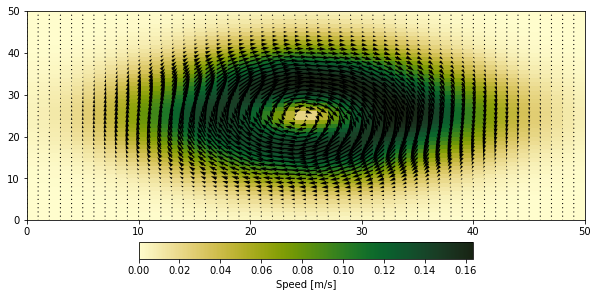

In [2]:
# A theoretical eddy
nx, ny = (50, 50)
x = np.linspace(-1, 0, nx)
y = np.linspace(0, 1, ny)
xv, yv = np.meshgrid(x, y)
u = np.pi*np.sin(np.pi*xv)*np.cos(np.pi*yv)
v = -np.pi*np.cos(np.pi*xv)*np.sin(np.pi*yv)

# weighten with a bell curve
x_weight = norm.pdf(np.arange(-3, 3, 6/nx),0,1)
y_weight = norm.pdf(np.arange(-3, 3, 6/ny),0,1)

#u/=np.pi
#v/=np.pi

for idx in range(u.shape[0]):
    u[idx,:] *= x_weight
    v[idx,:] *= x_weight

for idy in range(u.shape[1]):
    u[:,idy] *= y_weight
    v[:,idy] *= y_weight

#u*=x_weight
#v*=x_weight



fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(10,5))
pc0 = ax.pcolormesh(np.sqrt(u**2 + v**2),cmap=cmocean.cm.speed)
ax.quiver(u,v)
fig.colorbar(pc0,ax=ax,orientation='horizontal',shrink=0.6,pad=0.08,label="Speed [m/s]")

/tmp/ipykernel_419/720132631.py:17: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  pc0 = ax.pcolormesh(xx,yy,speed,cmap=cmocean.cm.speed)


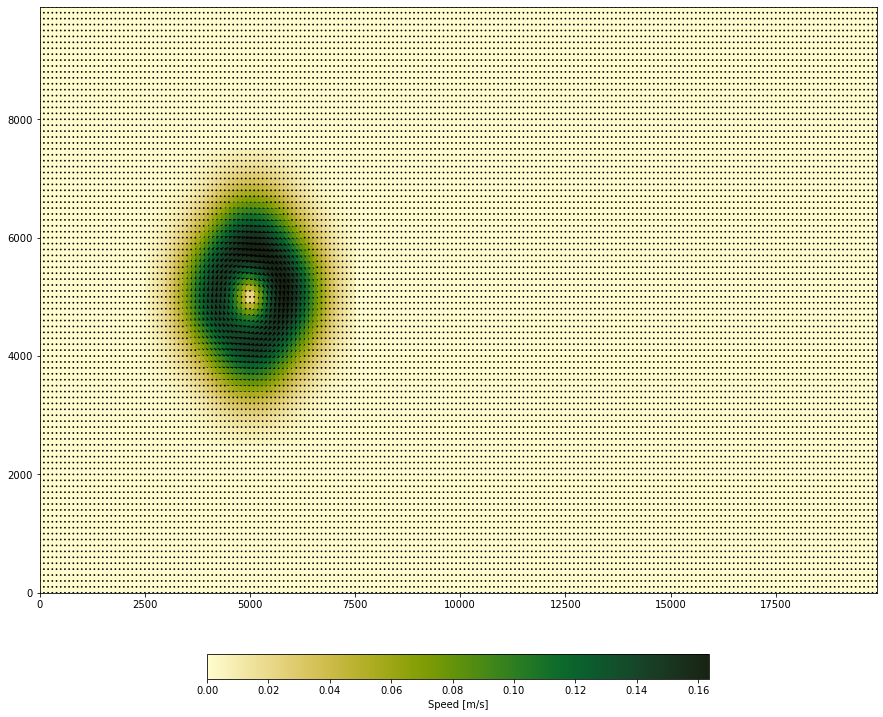

In [15]:
# Insert theoretical eddy in larger domain
dx=dy=100 #m

nny, nnx = (100,200)
yy = np.arange(nny)*dy
xx = np.arange(nnx)*dx
uu = np.zeros((nny,nnx))
vv = uu.copy()

uu[25:75,25:75] = u

vv[25:75,25:75] = v

speed = np.sqrt(uu**2 + vv**2)

fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(15,14))
pc0 = ax.pcolormesh(xx,yy,speed,cmap=cmocean.cm.speed)
ax.quiver(xx,yy,uu,vv,scale=25, scale_units='width')
fig.colorbar(pc0,ax=ax,orientation='horizontal',shrink=0.6,pad=0.08,label="Speed [m/s]")

In [17]:
nt = 24
U = np.zeros((nt,nny,nnx))
V = np.zeros((nt,nny,nnx))
SPEED = np.zeros((nt,nny,nnx))

temporal_weight=np.sin(np.linspace(0,np.pi,nt))

for idt,weight in enumerate(temporal_weight):
    U[idt,:,:] = weight*uu
    V[idt,:,:] = weight*vv
    SPEED[idt,:,:] = np.sqrt((weight*uu)**2 + (weight*vv)**2)

In [18]:
#Creating time variable

import datetime
T0 = np.datetime64('2000-01-01T00:00:00')
T = 3600 #[s]

#t_acq = np.arange('2000-01-01T00:00:00', '2000-01-02T00:00:00', dtype='datetime64[h]')
#t_acq = np.arange('2000-01-01T00:00:00', '2000-01-02T00:00:00', dtype='datetime64[h]')
t_acq = np.arange(T0, T0+np.timedelta64(T,'s'),np.timedelta64(int(((T/nt)*1e3)),'ms'))
t_acq = t_acq.astype('datetime64[s]')
td = t_acq-np.datetime64('1970-01-01T00:00:00','s') 

## Creating a current jet

In [46]:
U0 = .3
x_shifted = np.linspace(-np.pi,np.pi,nny)

U_y = U0*np.cos((x_shifted)/(0.55*np.pi))**4

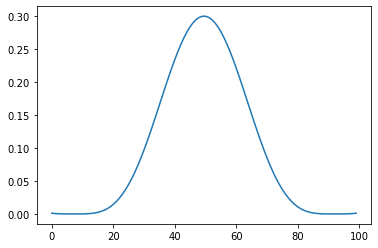

In [47]:
plt.plot(U_y)

In [67]:
U_jet = np.ones((nny,nnx)).T*U_y
U_jet = U_jet.T

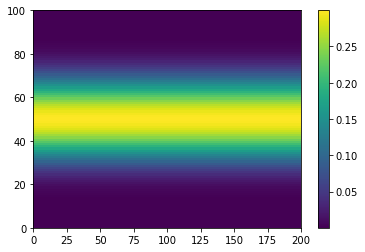

In [68]:
plt.pcolormesh(U_jet[:,:]);plt.colorbar()

## Creating a zero velocity field

In [70]:
U_zero = np.zeros((nt,nny,nnx))
V_zero = np.zeros((nt,nny,nnx))
SPEED_zero = np.zeros((nt,nny,nnx))

## Creating velocity field with constant vorticity
vertical vorticity
$$\zeta = \frac{\partial v}{\partial x} - \frac{\partial u}{\partial y}.$$

Make vertical vorticity constant to compute the wave deflection angle


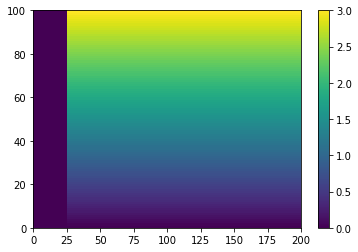

In [91]:
vertical_profile = np.linspace(0,3,nny)
U_vorticity = (np.ones((nny,nnx))).T*vertical_profile
U_vorticity[0:25,:] = 0
U_vorticity = U_vorticity.T
plt.pcolormesh(U_vorticity);plt.colorbar()

## Creating bathymetry fields

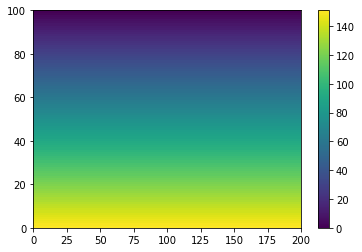

In [93]:
# Create bathymetry 2d_slope
xx_bat, yy_bat=np.meshgrid(np.linspace(1,0,nnx),np.linspace(1,0,nny))
depth=150

def f(xx,yy,slope):
    if slope=='linear':
        return(150*(xx*yy))
    elif slope=='bm': #bottom mountain
        return(np.sin(xx)*np.cos(yy))

bathymetry_2d_slope = f(xx_bat,yy_bat,slope='linear')

bathymetry_1dx_slope = xx_bat*(depth+1)
bathymetry_1dy_slope = yy_bat*(depth+1)


plt.pcolormesh(bathymetry_1dy_slope);plt.colorbar()

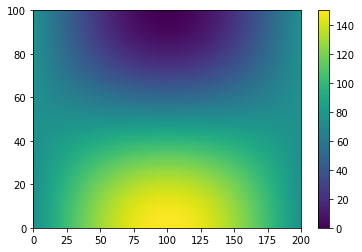

In [94]:
xx_bat_harmonic, yy_bat_harmonic=np.meshgrid(np.linspace(0,np.pi,nnx),np.linspace(0,np.pi,nny))
bottom_mountain = f(xx_bat_harmonic,yy_bat_harmonic,slope='bm')
bottom_mountain += bottom_mountain.max()
bottom_mountain /= bottom_mountain.max()
bottom_mountain *= depth

plt.pcolormesh(bottom_mountain);plt.colorbar()

In [95]:
nnx,nny,U_jet.shape

(200, 100, (100, 200))

# Store NetCDF file

In [96]:
# Create nc file
out_netcdf = 'idealized_input.nc'

with (netCDF4.Dataset(out_netcdf, 'w', format='NETCDF4')) as ncout:
    dim_time = ncout.createDimension('time',nt)
    dim_x = ncout.createDimension('x',nnx)
    dim_y = ncout.createDimension('y',nny)
    nctime = ncout.createVariable('time','i4',('time',))

    # Set time value
    ##########################################################
    nctime.long_name = 'reference time for eddy'
    nctime.units = 'seconds since 1970-01-01 00:00:00'
    nctime.calendar = 'gregorian'
    nctime[:] = td
    
    # Add projection coordinates
    ##########################################################
    # Status
    
    ncx = ncout.createVariable('x','i4', 'x', zlib=True)
    ncx.units = 'm'
    ncx.standard_name= 'projection_x_coordinate'
    ncx[:] = xx
    ncy = ncout.createVariable('y','i4', 'y', zlib=True)
    ncy.units = 'm'
    ncy.standard_name= 'projection_y_coordinate'
    ncy[:] = yy
    
    ### EDDY ###
    
    # ADD U eddy
    varout_u = ncout.createVariable('U',np.float32,
                    ('time', 'y', 'x'), zlib=True)
    varout_u.units = "meter second-1";                    
    varout_u.standard_name = 'x_sea_water_velocity'
    varout_u[:] = U#np.moveaxis(U, [2, 1], [1, 2])
    
    # ADD V eddy
    varout_v = ncout.createVariable('V',np.float32,
                    ('time', 'y', 'x'), zlib=True)
    varout_v.units = "meter second-1";                    
    varout_v.standard_name = 'y_sea_water_velocity'
    varout_v[:] = V
    
    # ADD SPEED eddy
    varout_sp = ncout.createVariable('speed',np.float32,
                    ('time', 'y', 'x'), zlib=True)
    varout_sp.units = "meter second-1";                    
    varout_sp.standard_name = 'speed'
    varout_sp[:] = SPEED
    
    ### Current jet ###
    
    # ADD U jet
    varout_u = ncout.createVariable('U_jet',np.float32,
                    ('y', 'x'), zlib=True)
    varout_u.units = "meter second-1";                    
    varout_u.standard_name = 'x_sea_water_velocity'
    varout_u[:] = U_jet#np.moveaxis(U, [2, 1], [1, 2])
    
    ### Zero velocity ###
    
    # ADD U zero
    varout_u = ncout.createVariable('U_zero',np.float32,
                    ('time', 'y', 'x'), zlib=True)
    varout_u.units = "meter second-1";                    
    varout_u.standard_name = 'x_sea_water_velocity'
    varout_u[:] = U_zero
    
    # ADD V zero
    varout_v = ncout.createVariable('V_zero',np.float32,
                    ('time', 'y', 'x'), zlib=True)
    varout_v.units = "meter second-1";                    
    varout_v.standard_name = 'y_sea_water_velocity'
    varout_v[:] = V_zero
    
    # ADD SPEED zero
    varout_sp = ncout.createVariable('speed_zero',np.float32,
                    ('time', 'y', 'x'), zlib=True)
    varout_sp.units = "meter second-1";                    
    varout_sp.standard_name = 'speed'
    varout_sp[:] = SPEED_zero
    
    ### Constant vorticity ###
    
    # ADD U vorticity
    varout_u = ncout.createVariable('U_vorticity',np.float32,
                    ('time', 'y', 'x'), zlib=True)
    varout_u.units = "meter second-1";                    
    varout_u.standard_name = 'x_sea_water_velocity'
    varout_u[:] = U_vorticity
    
    # ADD V vortivity (=zero)
    varout_v = ncout.createVariable('V_vorticity',np.float32,
                    ('time', 'y', 'x'), zlib=True)
    varout_v.units = "meter second-1";                    
    varout_v.standard_name = 'y_sea_water_velocity'
    varout_v[:] = V_zero    

    ### ADD bathymetry ###
    
    varout_sp = ncout.createVariable('bathymetry_2d_slope',np.float32,
                    ('y', 'x'), zlib=True)
    varout_sp.units = "meter";                    
    varout_sp.standard_name = 'depth'
    varout_sp[:] = bathymetry_2d_slope

    varout_sp = ncout.createVariable('bathymetry_1dx_slope',np.float32,
                    ('y', 'x'), zlib=True)
    varout_sp.units = "meter";                    
    varout_sp.standard_name = 'depth'
    varout_sp[:] = bathymetry_1dx_slope
            
    varout_sp = ncout.createVariable('bathymetry_1dy_slope',np.float32,
                    ('y', 'x'), zlib=True)
    varout_sp.units = "meter";                    
    varout_sp.standard_name = 'depth'
    varout_sp[:] = bathymetry_1dy_slope
    
    varout_sp = ncout.createVariable('bathymetry_bm',np.float32,
                    ('y', 'x'), zlib=True)
    varout_sp.units = "meter";                    
    varout_sp.standard_name = 'depth'
    varout_sp.long_name = 'bottom mountain'
    varout_sp[:] = bottom_mountain